# Priori analysis of TCGA BRCA

## Download input data

Now that we've set-up our environments for our analysis, we need to download and prepare our input data. For this demonstration, we will analyze normalized, bulk RNA-seq data from the TCGA Breast Invasive Carcinoma PanCancer Atlas. We will download the normalized expression as well as the metadata that we analyzed in our [pre-print](https://www.biorxiv.org/content/10.1101/2022.12.16.520295v2) from Zenodo. These files are also accessible on [cBioPortal](https://www.cbioportal.org/study/summary?id=brca_tcga_pan_can_atlas_2018).

In [ ]:
%%bash

# TCGA BRCA normalized gene expression
wget XXX

# TCGA BRCA metadata
wget XXX

## Prepare input data

Once the download is complete, we need to confirm that it is in the correct format. The gene expression counts should be normalized (any standard method, including CPM or TPM, is sufficient) and gene names should be listed as gene symbols. The gene names stored in a column labeled as "features". Lastly, there should be separate columns of normalized gene expression values for each sample. Label each column with the sample name.

In [1]:
%%bash

cut -d$'\t' -f 1-5 "tcga_brca_normalized_counts.tsv" | head

features	TCGA-3C-AAAU-01	TCGA-3C-AALI-01	TCGA-3C-AALJ-01	TCGA-3C-AALK-01
LOC100130426	0	0	0.9066	0
UBE2Q2P3	16.3644	9.2659	11.6228	12.0894
UBE2Q2P3.1	12.9316	17.379	9.2294	11.0799
HMGB1P1	52.1503	69.7553	154.2974	143.8643
TIMM23	408.076	563.8934	1360.8341	865.5358
MOXD2	0	0	0	0
LOC155060	1187.005	516.0413	592.0218	552.7513
RNU12.2P	0	1.0875	0	0.4137
SSX9	0	0.5438	0	0


## Generate Priori scores

We are now ready to generate Priori transcription factor activity scores. Priori can be called using the following arguments:

```
priori expr out_dir [--help] [--regulon "<value>"] [--regulon_size "<value>"] 
                    [--scaler_type "<value>"] [--thresh_filter "<value>"] 

Required arguments:
    expr                A tab-delimited normalized expression matrix of the shape 
                        [n_features, n_samples]
                        
    out_dir             Output directory where the serialized Priori object and 
                        priori activity scores will be saved

Optional arguments:

    --regulon           A prior network that contains the transcriptional regulators 
                        (Regulator), target genes (Target), edge weights (MoA), and
                        likelihood of interaction (likelihood). The network should be 
                        formatted as ['Regulator','Target','MoA','likelihood']
                        
    --regulon_size      Number of downstream target genes required for a given 
                        transcriptional regulator. Default = 15
                        
    --scaler_type       Method to scale normalized expression. Options include standard, 
                        robust, minmax, or quant. Default = robust.
                        
    --thresh_filter     Remove features with a standard deviation below this value. Default = 0.1.
```

Since we will be using the default Pathway Commons regulatory relationships to analyze this data, we only have to provide the expression dataset (`expr`) and the output directory (`out_dir`). 

Note: Calling Priori from Jupyter Notebooks can be slow (30 minutes - 1 hour to complete). This operation can also be called directly from the command line and is much faster.

In [ ]:
%%bash

priori tcga_brca_normalized_counts.tsv tcga_brca_priori_results

Loaded object from disk at /Users/yashar/miniconda3/envs/priori_tutorial_env/lib/python3.10/site-packages/priori/data/primary_intx_regulon.pkl
------
n-features: 20531
n-samples: 1100
scaler: None
scaled:        False
regulon threshold: 15
regulon nodes: 1513
regulon edges: 122785
------


Scaling data...

--- log2 normalization ---
--- Centering features with robust scaler ---

Data scaled!


Assigning weights...


Weights assigned!


Calculating enrichment...

--- Calculating regulon enrichment scores ---


## Change kernel

Now that we've generated Priori scores, we can analyze them to identify potential transcription factor regulators of breast invasive ductal carcinoma (BIDC). Since the remainder of the analysis will be performed in R, we need to change the jupyter notebook kernel. To do this, navigate to the toolbar, select "Kernel" -> "Change kernel" -> "R".

# Analyze Priori scores

## Load Libraries

Here, we will load the packages needed to analyze the Priori scores. 

In [1]:
library(tidyverse)
library(ggpubr)
library(Seurat)
library(patchwork)
library(cowplot)

── Attaching core tidyverse packages ───────────────────────────────────────────────────────────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.3     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ ggplot2   3.4.3     ✔ tibble    3.2.1
✔ lubridate 1.9.2     ✔ tidyr     1.3.0
✔ purrr     1.0.2     
── Conflicts ─────────────────────────────────────────────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
The legacy packages maptools, rgdal, and rgeos, underpinning the sp package,
which was just loaded, will retire in October 2023.
Please refer to R-spatial evolution reports for details, especially
https://r-spatial.org/r/2023/05/15/evolution4.html.
It may be desirable to make the sf package available;
package maintainers should consider adding sf to Suggests:.
The sp 

## Custom functions

Load the custom functions that aid in visualization of the PCA and UMAP results.

In [8]:
# Manuscript plot colors
plot_cols <- c("#2F639B", "#4DA4D2")

# Plot PCA with x and y density plots
plot_pca <- function(seurat_object, color_by){
  
  # Extract UMAP coordinates
  regulon_embed <- as.data.frame(seurat_object@reductions$pca@cell.embeddings)
  regulon_embed$Sample_ID <- rownames(regulon_embed)
  clinical_data <- as.data.frame(so_subtype@meta.data)
  clinical_data$Sample_ID <- rownames(clinical_data)
  clinical_p3_umap <- left_join(clinical_data, regulon_embed)
  
  # Main plot
  pmain <- ggscatter(clinical_p3_umap, x = "PC_1", y = "PC_2", color = color_by, size = 3) +
    scale_fill_manual(values = plot_cols) +
    scale_color_manual(values = plot_cols)
  
  # Marginal densities along x axis
  xdens <- axis_canvas(pmain, axis = "x")+
    geom_density(data = clinical_p3_umap, aes_string(x = "PC_1", fill = color_by),
                alpha = 0.7, size = 0) +
    scale_fill_manual(values = plot_cols) +
    scale_color_manual(values = plot_cols)
  
  # Marginal densities along y axis
  # Need to set coord_flip = TRUE, if you plan to use coord_flip()
  ydens <- axis_canvas(pmain, axis = "y", coord_flip = TRUE)+
    geom_density(data = clinical_p3_umap, aes_string(x = "PC_2", fill = color_by),
                  alpha = 0.7, size = 0) +
    scale_fill_manual(values = plot_cols) +
    scale_color_manual(values = plot_cols) +
    coord_flip()
  
  # Create plots 
  p1 <- insert_xaxis_grob(pmain, xdens, grid::unit(.1, "null"), position = "top")
  p2 <- insert_yaxis_grob(p1, ydens, grid::unit(.1, "null"), position = "right")
  
  return(p2)
}

# Plot UMAP with x and y density plots
plot_umap <- function(seurat_object, color_by){
  
  # Extract UMAP coordinates
  regulon_embed <- as.data.frame(seurat_object@reductions$umap@cell.embeddings)
  regulon_embed$Sample_ID <- rownames(regulon_embed)
  clinical_data <- as.data.frame(so_subtype@meta.data)
  clinical_data$Sample_ID <- rownames(clinical_data)
  clinical_p3_umap <- left_join(clinical_data, regulon_embed)
  
  # Main plot
  pmain <- ggscatter(clinical_p3_umap, x = "UMAP_1", y = "UMAP_2", color = color_by, size = 3) +
    scale_fill_manual(values = plot_cols) +
    scale_color_manual(values = plot_cols)
  
  # Marginal densities along x axis
  xdens <- axis_canvas(pmain, axis = "x")+
    geom_density(data = clinical_p3_umap, aes_string(x = "UMAP_1", fill = color_by),
                alpha = 0.7, size = 0) +
    scale_fill_manual(values = plot_cols) +
    scale_color_manual(values = plot_cols)
  
  # Marginal densities along y axis
  # Need to set coord_flip = TRUE, if you plan to use coord_flip()
  ydens <- axis_canvas(pmain, axis = "y", coord_flip = TRUE)+
    geom_density(data = clinical_p3_umap, aes_string(x = "UMAP_2", fill = color_by),
                  alpha = 0.7, size = 0) +
    coord_flip() +
    scale_fill_manual(values = plot_cols) +
    scale_color_manual(values = plot_cols)
  
  # Create plots 
  p1 <- insert_xaxis_grob(pmain, xdens, grid::unit(.1, "null"), position = "top")
  p2 <- insert_yaxis_grob(p1, ydens, grid::unit(.1, "null"), position = "right")
  
  return(p2)
}

## Load data

Load the Priori scores that we generated above as well as the TCGA BRCA clinical metadata.

In [4]:
# Priori Scores
priori_scores <- read.table("tcga_brca_priori_results/priori_activity_scores.tsv", sep = "\t", header = TRUE, stringsAsFactors = FALSE, check.names = FALSE)

# Clinical data
clinical <- as_tibble(read.table("tcga_brca_metadata.tsv", sep = "\t", header = TRUE, stringsAsFactors = FALSE, check.names = FALSE))

## Filter clinical data

In [5]:
# Create results directory
results_path <- "results"
dir.create(results_path, showWarnings = FALSE, recursive = TRUE)

# Select relevant columns
clinical_filt <- clinical %>% 
    dplyr::select("Sample ID", # Patient identification
                  "Subtype", # Filtering and main analysis
                  "Cancer Type Detailed" # Pathologically-defined breast cancer types
         ) 

# Change spaces to underscores
colnames(clinical_filt) <- unlist(lapply(colnames(clinical_filt), str_replace_all, pattern = " ", replacement = "_"))

# Filter by patients with regulon scores
clinical_filt <- clinical_filt[clinical_filt$Sample_ID %in% unlist(priori_scores[,1]),]

# Reformat subtypes
clinical_filt$Subtype <- unlist(lapply(clinical_filt$Subtype, sub, pattern = "BRCA_", replacement = ""))
clinical_filt$Subtype[is.na(clinical_filt$Subtype)] <- "NOS"

# Retain only Breast Invasive Ductal Carcinoma patients
clinical_filt <- clinical_filt[clinical_filt$Cancer_Type_Detailed == "Breast Invasive Ductal Carcinoma",]

# Filter out subtypes other than Basal and LumA/B
# Combine LumA/B
clinical_subtype_filt <- clinical_filt[ ( clinical_filt$Subtype == "Basal" | clinical_filt$Subtype == "LumA" | clinical_filt$Subtype == "LumB" ) ,]
clinical_subtype_filt$Subtype_combined <- "Basal"
clinical_subtype_filt$Subtype_combined[clinical_subtype_filt$Subtype == "LumA"] <- "Luminal"
clinical_subtype_filt$Subtype_combined[clinical_subtype_filt$Subtype == "LumB"] <- "Luminal"

head(clinical_subtype_filt)

Sample_ID,Subtype,Cancer_Type_Detailed,Subtype_combined
<chr>,<chr>,<chr>,<chr>
TCGA-3C-AALJ-01,LumB,Breast Invasive Ductal Carcinoma,Luminal
TCGA-3C-AALK-01,LumA,Breast Invasive Ductal Carcinoma,Luminal
TCGA-A1-A0SD-01,LumA,Breast Invasive Ductal Carcinoma,Luminal
TCGA-A1-A0SF-01,LumA,Breast Invasive Ductal Carcinoma,Luminal
TCGA-A1-A0SH-01,LumA,Breast Invasive Ductal Carcinoma,Luminal
TCGA-A1-A0SI-01,LumB,Breast Invasive Ductal Carcinoma,Luminal


## Scale data and identify top variable features

In [6]:
# Filter and re-order by clinical metadata
priori_scores_subtype_filt <- priori_scores[unlist(priori_scores[,1]) %in% clinical_subtype_filt$Sample_ID,]
priori_scores_subtype_filt <- priori_scores_subtype_filt[order(unlist(priori_scores_subtype_filt[,1]), clinical_subtype_filt$Sample_ID),]

# Re-format scores
priori_scores_form <- priori_scores_subtype_filt[,-1]
rownames(priori_scores_form) <- unlist(priori_scores_subtype_filt[,1])
t_priori_scores_form <- t(priori_scores_form)

# Create Seurat Object
so_subtype <- CreateSeuratObject(counts = t_priori_scores_form)

# Add metadata
so_subtype@meta.data <- cbind(so_subtype@meta.data, clinical_subtype_filt[,-1])

# Identify variable regulons
so_subtype <- FindVariableFeatures(so_subtype, selection.method = "dispersion", nfeatures = 100)

# Scale regulon scores
all_regs <- rownames(so_subtype)
so_subtype <- ScaleData(so_subtype, features = all_regs)

Centering and scaling data matrix



## Dimensional reduction

PC_ 1 
Positive:  MYOD1, SPZ1, PDX1, CEBPB, NHLH1, CDX2, NR1H4, HMGA1, ETV4, TFAP2C 
	   FOXD3, FOXA2, CRX, EN1, ELK1, MYC, TCF3, LHX3, SOX9, TBP 
	   HAND1, CARM1, PAX4, ATF4, ESR2, SRF, RXRB, ESRRA, MAFG, EGR4 
Negative:  PAX2, GCM1, GATA2, CBFA2T3, TEF, RXRA, PAX8, NR2F2, GATA1, STAT5B 
	   MAX, STAT6, NCOA1, DBP, IRF2, CAT, FOXO4, IGF1, TNFSF10, EGR3 
	   TGIF1, ZBTB18, HELZ2, PTGDR, HOXA5, MSX1, SMARCD3, FOXF2, RFX1, NOG 
PC_ 2 
Positive:  MEIS1, HOXA4, NOG, ZBTB18, PAX3, EGR1, HOXA5, PITX2, FOXF2, POU6F1 
	   HLF, JUN, FGF2, HOXA9, LMO2, EGR3, ETS2, STAT5A, ATF3, JUNB 
	   IGF1, NGF, PTGDR, PRRX2, FOS, STAT5B, MSX1, CAT, GATA1, FOXI1 
Negative:  PAX4, INS, LHX3, REPIN1, ELK1, CRX, PTF1A, HELZ2, TBP, MYC 
	   HMGA1, FOXA2, PDX1, NHLH1, ATF4, NRF1, ESRRA, MYOD1, HAND1, E4F1 
	   FOXD3, ETV4, DBP, SPZ1, RXRB, TFAP2C, NFE2, MAFG, TGIF1, TCF3 
PC_ 3 
Positive:  E4F1, RFX1, REPIN1, NRF1, DBP, INS, NFE2, TGIF1, CEBPD, ESRRA 
	   MAX, CEBPA, SMARCD3, PAX8, NR1H3, RXRB, STAT6, RXRA, ATF4,

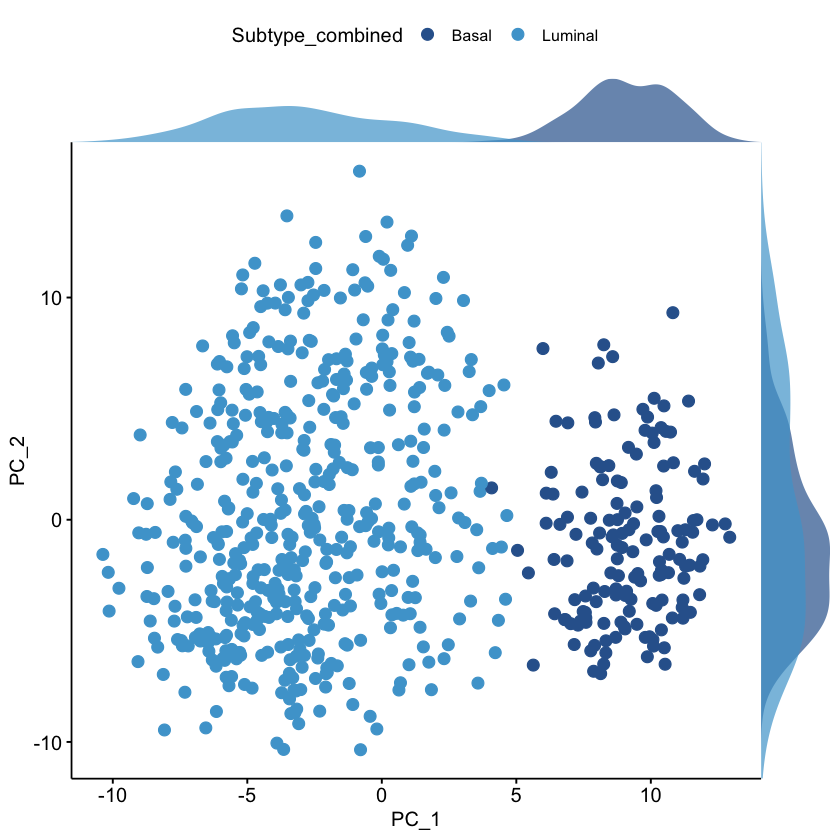

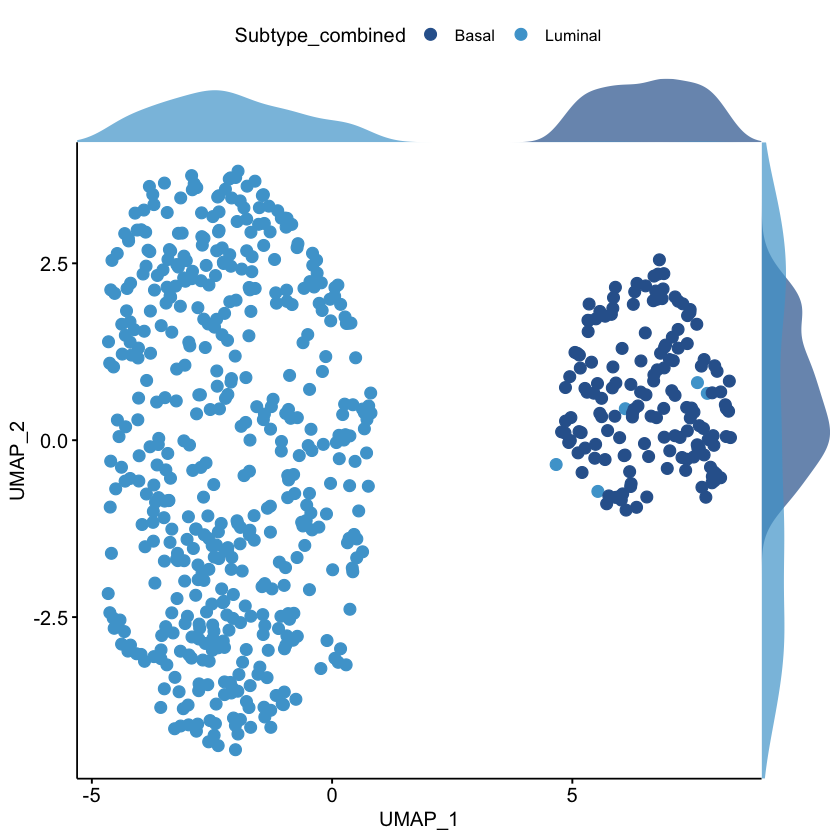

In [ ]:
# Perform PCA
so_subtype <- RunPCA(so_subtype, features = VariableFeatures(object = so_subtype), approx = FALSE)

# PCA with density plots
p <- plot_pca(so_subtype, "Subtype_combined")
ggdraw(p)
ggsave(sprintf("%s/pca_density_subtype.pdf", results_path), dev = "pdf", height = 7.5, width = 6.75)

# Calculate UMAP
so_subtype <- RunUMAP(so_subtype, dims = 1:10)

# UMAP with density plots
p <- plot_umap(so_subtype, "Subtype_combined")
ggdraw(p)
ggsave(sprintf("%s/umap_density_subtype.pdf", results_path), dev = "pdf", height = 7.5, width = 6.75)

## Conclusion

In this tutorial, we demonstrated how Priori could be used to understand transcription factor drivers of disease. We used Priori to generate transcription factor activity scores for 637 patients with invasive breast ductal carcinoma (BIDC) from the TCGA BRCA cohort. The Priori scores from these patients clustered by breast cancer subtypes: luminal (light blue) and basal (dark blue) cancers. These subtypes are the most common molecular subtypes in breast cancer and can distinguished by hormone receptor expression. In our [pre-print](https://www.biorxiv.org/content/10.1101/2022.12.16.520295v2), we use these findings to reveal the transcription factor activity differences between these subtypes as well as nominate a transcription factor, FOXA1, as a regulator of survival in BIDC.